<a href="https://colab.research.google.com/github/AleemRahil/GAMs_for_Pricing_Optimization_Strategy/blob/main/GAMs_for_Pricing_Optimization_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PYTHON GAM PRICE OPTIMIZATION

## PART 1: EXPECTILE GAM PRIMER

### Showcases the use of Expectile GAM (Primer for Price Optimization)

In [2]:
pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 5.6 MB/s eta 0:00:00


In [97]:
# prompt: import numpy, pandas, plt pygam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import s, ExpectileGAM



In [98]:
# Data Generation
np.random.seed(0)
n = 100
price = np.sort(np.random.exponential(scale=100, size =n))
quantity = 1000 - 5*price + np.random.normal(loc=0, scale=50, size=n)
quantity = quantity.clip(min=0)

In [99]:
# Add Outliers
n_outliers = 10
outlier_prices = np.random.uniform(5, 50, n_outliers)
outlier_quantity = 1100 + np.random.normal(loc=0, scale=50, size=n_outliers)
price = np.concatenate([price, outlier_prices])
quantity = np.concatenate([quantity, outlier_quantity])

In [100]:
# Add Outliers
n_outliers = 10
outlier_prices = np.random.uniform(51, 100, n_outliers)
outlier_quantity = 900 + np.random.normal(loc=0, scale=50, size=n_outliers)
price = np.concatenate([price, outlier_prices])
quantity = np.concatenate([quantity, outlier_quantity])

In [101]:
df = pd.DataFrame({
    'Price': price,
    'Quantity': quantity
})


In [102]:
# Filer out prices less than 5
df = df[df['Price'] >= 5]

In [103]:
df

,Price,Quantity
5,6.211530,1063.736811
6,6.629740,1025.790280
7,7.368535,954.161081
8,9.116103,900.881854
9,9.865031,1003.397430
...,...,...
115,65.315229,863.098455
116,62.800610,913.996230
117,55.914403,895.092481
118,51.805052,945.508945


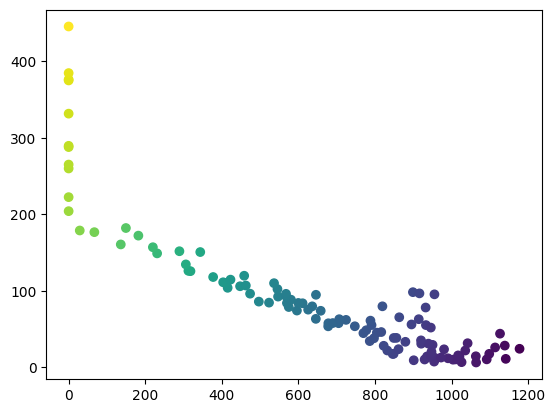

In [104]:
# @title Price and Quantity Spread vs Mean

import matplotlib.pyplot as plt
_ = plt.scatter(df['Quantity'], df['Price'], c=df['Price'] - df['Quantity'])

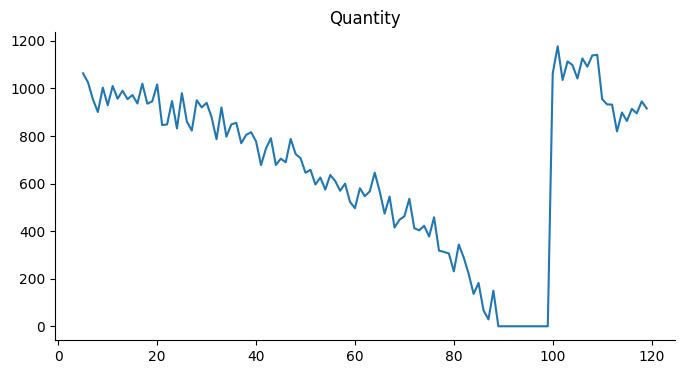

In [105]:
# @title Quantity

from matplotlib import pyplot as plt
df['Quantity'].plot(kind='line', figsize=(8, 4), title='Quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

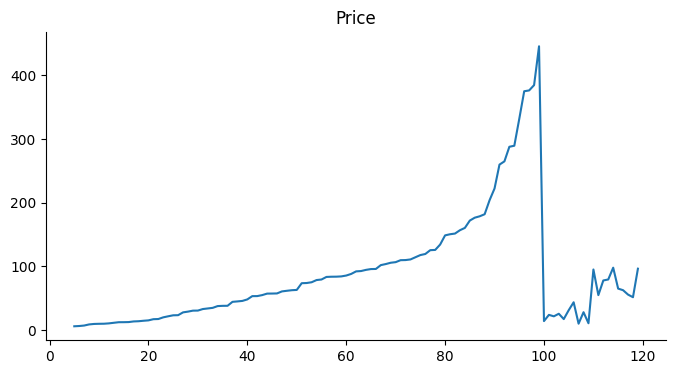

In [106]:
# @title Price

from matplotlib import pyplot as plt
df['Price'].plot(kind='line', figsize=(8, 4), title='Price')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: ylabel='Frequency'>

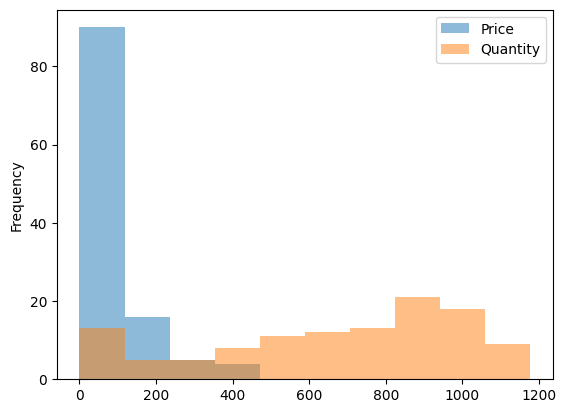

In [107]:
# @title Distribution of Price vs Quantity

df.plot.hist(column=['Price', 'Quantity'], alpha=0.5)

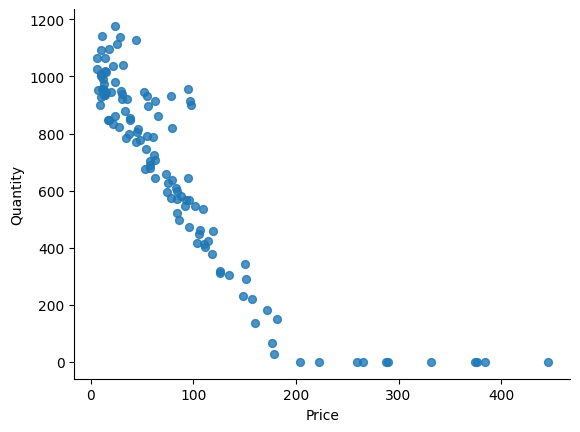

In [108]:
# @title Price vs Quantity

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Price', y='Quantity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

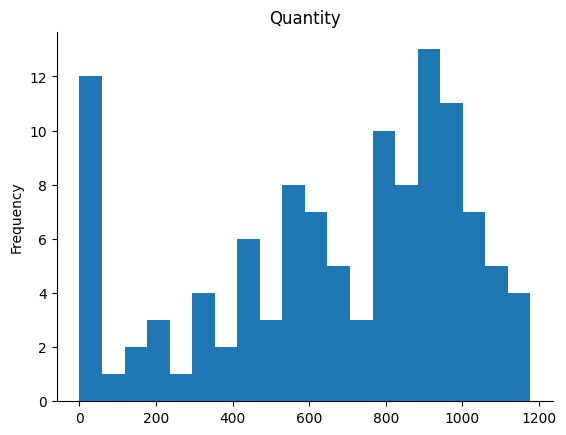

In [109]:
# @title Quantity

from matplotlib import pyplot as plt
df['Quantity'].plot(kind='hist', bins=20, title='Quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)

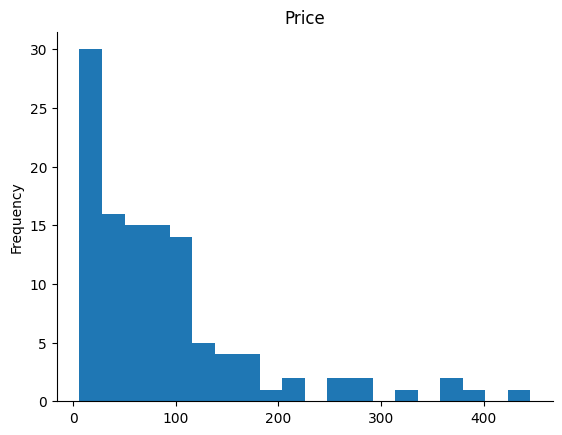

In [110]:
# @title Price

from matplotlib import pyplot as plt
df['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Modeling

In [111]:
# Reshape Data
X = df[['Price']]
y = df['Quantity']

# Quantile GAMs
quantiles = [0.025, 0.5, 0.975]
gam_results = {}

for q in quantiles:
  gam = ExpectileGAM(s(0), expectile=q)
  gam. fit(X,y)
  gam_results[q] = gam

In [112]:
gam_results

{0.025: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.025, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False),
 0.5: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.5, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False),
 0.975: ExpectileGAM(callbacks=[Deviance(), Diffs()], expectile=0.975, 
    fit_intercept=True, max_iter=100, scale=None, 
    terms=s(0) + intercept, tol=0.0001, verbose=False)}

# Visualization

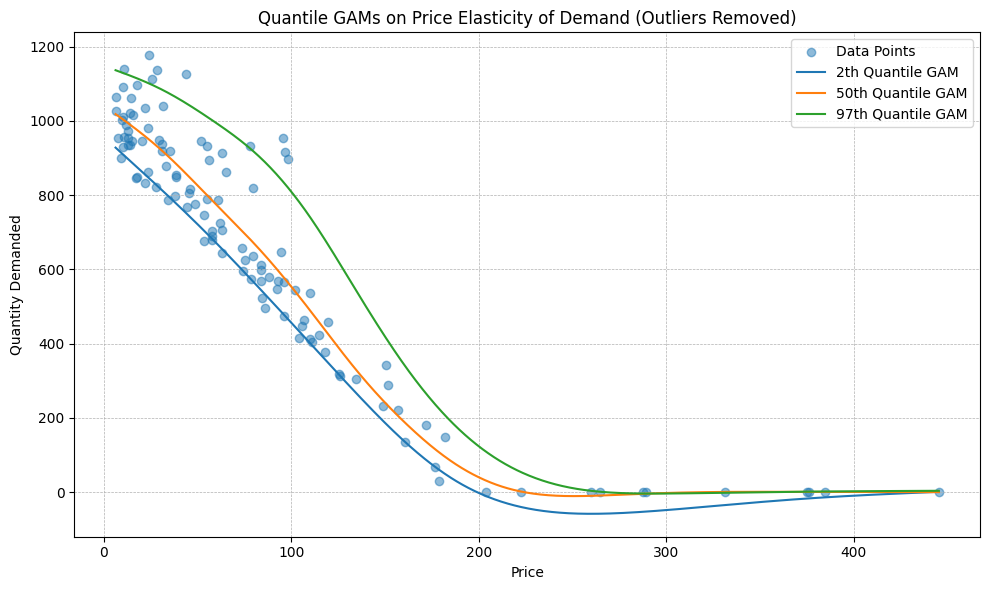

In [113]:
# Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(df['Price'], df['Quantity'], alpha=0.5, label='Data Points')

# Plot Quantile GAMs
XX = np.linspace(df['Price'].min(), df['Price'].max(), 1000).reshape(-1,1)
for q, gam in gam_results.items():
  plt.plot(XX, gam.predict(XX), label=f'{int(q*100)}th Quantile GAM')

# Add titles and labels
plt.xlabel('Price')
plt.ylabel('Quantity Demanded')
plt.title('Quantile GAMs on Price Elasticity of Demand (Outliers Removed)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Price Optimization
## PART 2: EXPECTILE GAM PRICE OPTIMIZATION

In [1]:
pip install pytimetk

In [2]:
# Data Analysis and Modeling
import statsmodels.api as sm
from pygam import GAM, ExpectileGAM, s, l, f
from sklearn.preprocessing import LabelEncoder

# Visualisation
import plotly.express as px
from plotnine import *
import pytimetk as tk
import textwrap

In [113]:
# Load Data
data = pd.read_csv('data/price_optimization.csv')

In [ ]:
data

In [ ]:
data.describe(include='all').T

### 2.0 Data Preparation

In [ ]:
data['is_event'] = (data['event'] != "No Promo").astype(int).astype(str)

In [ ]:
data['revenue'] = data['price'] * data['quantity_sold']

In [ ]:
data

### EDA

#### Trends: Price vs Quantity Sold

In [3]:
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold',
    color = 'product',
    opacity=0.6,
    trendline = 'lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Price vs Quantity Analysis',
    width=800,
    height=600
).update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10))
).update_layout(
    legend_title_text = 'Product',
    title_font=dict(size=16),
    legend_font=dict(size=10)
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10)
).update_yaxes(
    title_text='Quantity Sold',
    title_font=dict(size=10),
    tickfont=dict(size=10)
)

In [ ]:
fig

#### EVENT ANALYSIS (OUTLIERS)

In [ ]:
# Scatter Plot
fig = px.scatter(
    data,
    x='price',
    y='quantity_sold',
    color = 'event',
    facet_col = 'product',
    facet_col_wrap=2,
    facet_col_spacing=0.1,
    facet_row_spacing=0.1,
    opacity=0.6,
    trendline = 'lowess',
    trendline_color_override='blue',
    template='none',
    title='Product Sales: Event Analysis',
    width=800,
    height=700
).update_traces(
    marker=dict(size=7),
    hoverlabel=dict(font=dict(size=10))
).update_layout(
    legend_title_text = 'Product',
    title_font=dict(size=16),
    legend_font=dict(size=10)
).update_xaxes(
    title_text='Price',
    title_font=dict(size=10),
    tickfont=dict(size=10)
).update_yaxes(
    title_text='Quantity Sold',
    title_font=dict(size=10),
    tickfont=dict(size=10)
)

for annotation in fig['layout']['annotations']:
  annotation['font'] = dict(size=10)

fig.for_each_xaxis(lambda axis: axis.update(showticklabels=True))
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))

In [ ]:
fig

#### Modeling Event Impact

In [ ]:
df_encoded = data.copy()
df_encoded = pd.get_dummies(df_encoded, columns=['event', 'product'], drop_first=False)

In [ ]:
colnames_event = df_encoded.columns[df_encoded.columms.str.startswith('event')].tolist()

In [ ]:
df_encoded['colnames_event'] = df_encoded[colnames_event].astype(int)

In [ ]:
colnames_product = df_encoded.columns[df_encoded.columns.str.startswith('product')].tolist()

In [ ]:
df_encoded[colnames_product] = df_encoded[colnames_product].astype(int)

In [ ]:
df_encoded

In [ ]:
X = df_encoded[['price'] + colnames_event + colnames_product]

In [ ]:
X = sm.add_constant(X) # Adds a constant to the model (intercept)

In [ ]:
y = df_encoded['quantity_sold']

In [ ]:
model = sm.OLS(y, X).fit()

In [ ]:
model.summary()

In [ ]:
model.params

In [ ]:
params_df = pd.DataFrame(model.params).T

In [ ]:
params_df

In [ ]:
np.log((params_df['event_Black Friday'] + params_df['const']) / (params_df['event_No Promo'] + params_df['const']))

#### General Price Optimization: GAMs

##### PROBLEM: Prices are not Linear
##### SOLUTION: Use GAMs (Generalized Additive Models)
##### NOTES:
#####       - GAMs are like Linear Regression, but allow for non-linear relationships
#####       - NOT as useful for incorporating events (see next section)




In [ ]:
# Keep the entire data as filtered
data_filtered = data.query('event == "No Promo"')

In [ ]:
# Create a list of unique Products
unique_products = data_filtered['product'].unique()

In [ ]:
# Create an empty dataframe to store the concatenated results
all_gam_results = pd.DataFrame()

In [ ]:
# Loop through each product
for product in unique_products:
  # Filter data for the current product
  product_data = data_filtered[data_filtered['product'] == product]

  X = product_data[['price']]
  y = product_data['quantity_sold']

  quantiles = [0.025, 0.5, 0.975]
  gam_results = {}

  # Fit the GAM model for the filtered data
  for q in quantiles:
    gam = ExpectileGAM(s(0), expectile=q)
    gam.fit(X, y)
    gam_results[f"pred_{q}"] = gam.predict(X)

  # Store the results in a dataframe with index that matches the original data
  predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

  # Concatenate the results column-wise with the original data
  predictions_gam_df = pd.concat([all_gam_results, predictions_gam_df], axis =0)

In [ ]:
all_gam_results

In [ ]:
# Visualize the GAM Price Model Results
ggplot(
    data = all_gam_results,
    mapping = aes(x='price', y='quantity_sold', color='product', group = 'product')
  ) + \
  geom_ribbon(aes(ymax = 'pred_0.975', ymin = 'pred_0.025'), fill = '#d3d3d3', color='#FF000000', alpha=0.75, show_legend = False) + \
  geom_point(alpha=0.5) + \
  geom_line(aes(y='pred_0.5'), color = 'blue') + \
  facet_wrap('product', scales='free') + \
  labs(title = 'GAM Price vs Quantity Model') + \
  scale_color_manual(values = list(tk.palette_timetk().values())) + \
  tk.theme_timetk(width = 800, height = 600)

In [ ]:
# Optimiza Price for Predicted Daily Revenue

for col in all_gam_results.columns:
  if col.startswith('pred'):
    all_gam_results['revenue_' + col] = all_gam_results['price']*all_gam_results[col]

all_gam_results['revenue_actual'] = all_gam_results['price']*all_gam_results['quantity_sold']

In [ ]:
all_gam_results

In [ ]:
best_50 = all_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1)).reset_index(level=0, drop=True)

In [ ]:
best_975 = all_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1)).reset_index(level=0, drop=True)

In [ ]:
best_025 = all_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1)).reset_index(level=0, drop=True)

In [ ]:
# Visualize the GAM Revenue Optimization Results

(
  ggplot(
      data = all_gam_results,
      mapping = aes(x='price', y='revenue_pred_0.5', color='product', group = 'product')
  ) + \
    geom_ribbon(aes(ymax = 'revenue_pred_0.975', ymin = 'revenue_pred_0.025'), fill = '#d3d3d3', color='#FF000000', alpha=0.5, show_legend = False) + \
    # Uncomment to add actual revenue points
    geom_point(aes(ymax = 'revenue_actual'),  color='#FF000000', alpha=0.5) + \
    geom_line(aes(y='revenue_pred_0.5'), alpha=0.5) + \
    geom_point(data=best_50, color='red') + \
    geom_point(data=best_975, mapping = aes(y='revenue_pred_0.975') , color='blue') + \
    geom_point(data=best_025, mapping = aes(y='revenue_pred_0.025') , color='blue') + \
    # geom_line(aes(y='pred_0.5'), color = 'blue') + \
    facet_wrap('product', scales='free') + \
    labs(
        title = 'iPhone Case Price Optimization',
        subtitle = 'Max Median Revenue (Red) vs 95% Max Confidence Interval (Blue)',
        x='Price',
        y='Predicted Revenue'
        ) + \
    scale_color_manual(values = list(tk.palette_timetk().values())) + \
    tk.theme_timetk(width = 800, height = 600)
)

In [ ]:
best_50[['product', 'price', 'revenue_pred_0.5', 'revenue_pred_0.025', 'revenue_pred_0.975']]

# BUSINESS INSIGHTS

###### 1. The GAMs show that the optimal price is at the ends of the price range for: Premium Case | iPhone 15 Pro Max Standard Case | iPhone 15 Pro Max
###### This suggests that the company should consider a price increase for these models

###### 2. The GAMS show that the optimal price is in the middle of the price range for Premium Case | iPhone 15 Pro and Standard Case | iPhone 15 Pro
###### This suggest that the company should consider a price that is close to the red dots for these products

# MODELING GAMS WITH EVENTS:

## Essentially the same process as above, but we need to filter out the "No Promo" events

## Gets a little tricky because of limited data points for each event

In [ ]:
#Keep the entire data as data_filtered
data_filtered = data.query('event != "No Promo"')


In [ ]:
# Create a list of unique products and events
unique_products = data_filtered['product'].unique()
events_only_gam_results = pd.DataFrame()


In [ ]:
# Loop through each product
for product in unique_products:

  #Filter data for the current product and event
  product_event_data = data_filtered[(data_filtered['product'] == product)]

  if len(product_event_data) ==0:
    continue # skip to next iteration if no data for current product-event combination

  X = product_event_data[['price', 'event']]
  y = product_event_data['quantity_sold']

  # NEW: Encode the event columm
  le = LabelEncoder()
  X['event'] = le.fit_transform(X['event'])

  #NEW: use f(1) to indicate that the event column is categorical
  gam = GAM(l(0) + f(1))

  gam.fit(X, y)
  gam_results[f"pred_0.5"] = gam.predict(X)

  # Store the results in a dataframe with index that matches the original data
  predictions_gam = pd.DataFrame(gam_results).set_index(X.index)

  # Concatenate the results column-wise with the original data
  predictions_gam_df = pd.concat([product_event_data[['price', 'product', 'event', 'quantity_sold']], predictions_gam], axis =1)

  # Concatenate results row-wise
  events_only_gam_results = pd.concat([events_only_gam_results, predictions_gam_df], axis=0)


In [ ]:
events_only_gam_results

In [ ]:
# Visualize the GAM Price Model Results
ggplot(
    data = events_only_gam_results,
    mapping = aes(x='price', y='quantity_sold', color='product', group = 'product')
  ) + \
  geom_ribbon(aes(ymax = 'pred_0.975', ymin = 'pred_0.025'), fill = '#d3d3d3', color='#FF000000', alpha=0.75, show_legend = False) + \
  geom_point(alpha=0.5) + \
  geom_line(aes(y='pred_0.5'), color = 'blue') + \
  facet_wrap('product', scales='free') + \
  labs(title = 'GAM Price vs Quantity Model') + \
  scale_color_manual(values = list(tk.palette_timetk().values())) + \
  tk.theme_timetk(width = 800, height = 600)

In [ ]:
# Optimiza Price for Predicted Daily Revenue

for col in events_only_gam_results.columns:
  if col.startswith('pred'):
    events_only_gam_results['revenue_' + col] = events_only_gam_results['price']*all_gam_results[col]

events_only_gam_results['revenue_actual'] = events_only_gam_results['price']*all_gam_results['quantity_sold']

In [ ]:
events_only_gam_results

In [ ]:
best_50 = events_only_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.5'] == x['revenue_pred_0.5'].max()].head(1)).reset_index(level=0, drop=True)

In [ ]:
best_975 = events_only_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.975'] == x['revenue_pred_0.975'].max()].head(1)).reset_index(level=0, drop=True)

In [ ]:
best_025 = events_only_gam_results \
  .groupby('product') \
  .apply(lambda x: x[x['revenue_pred_0.025'] == x['revenue_pred_0.025'].max()].head(1)).reset_index(level=0, drop=True)

In [ ]:
# Visualize the GAM Revenue Optimization Results

(
  ggplot(
      data = events_only_gam_results,
      mapping = aes(x='price', y='revenue_pred_0.5', color='product', group = 'product')
  ) + \
    geom_ribbon(aes(ymax = 'revenue_pred_0.975', ymin = 'revenue_pred_0.025'), fill = '#d3d3d3', color='#FF000000', alpha=0.5, show_legend = False) + \
    # Uncomment to add actual revenue points
    geom_point(aes(ymax = 'revenue_actual'),  color='#FF000000', alpha=0.5) + \
    geom_line(aes(y='revenue_pred_0.5'), alpha=0.5) + \
    geom_point(data=best_50, color='red') + \
    geom_point(data=best_975, mapping = aes(y='revenue_pred_0.975') , color='blue') + \
    geom_point(data=best_025, mapping = aes(y='revenue_pred_0.025') , color='blue') + \
    # geom_line(aes(y='pred_0.5'), color = 'blue') + \
    facet_wrap('product', scales='free') + \
    labs(
        title = 'iPhone Case Price Optimization',
        subtitle = 'Max Median Revenue (Red) vs 95% Max Confidence Interval (Blue)',
        x='Price',
        y='Predicted Revenue'
        ) + \
    scale_color_manual(values = list(tk.palette_timetk().values())) + \
    tk.theme_timetk(width = 800, height = 600)
)

In [ ]:
best_50[['product', 'price', 'revenue_pred_0.5', 'revenue_pred_0.025', 'revenue_pred_0.975']]